# Active regression with Committee
With an ensemble of regressors, the standard deviation of the predictions at a given point can be thought of as a measure of disagreement. This can be used for active regression. In the following example, we are going to see how can it be done using the CommitteeRegressor class.

The executable script for this example can be [found here!](https://github.com/cosmic-cortex/modAL/blob/master/examples/ensemble_regression.py)

## The dataset
For the sake of this example, we are going to learn the *noisy absolute value* function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

In [2]:
# generating the data
X = np.concatenate((np.random.rand(100)-1, np.random.rand(100)))
y = np.abs(X) + np.random.normal(scale=0.2, size=X.shape)

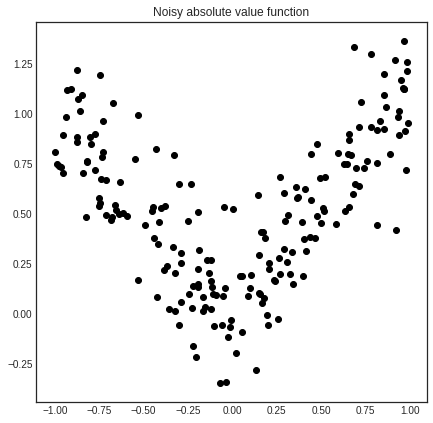

In [3]:
# visualizing the data
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.scatter(X, y, c='k')
    plt.title('Noisy absolute value function')
    plt.show()

## Measuring disagreement with CommitteeRegression
If you have several regressors, measuring disagreement can be done by calculating the standard deviation of the predictions for each point. This of course cannot be achieved with classifier algorithms, where averaging the class labels doesn't make sense. (Or it is undefined even, if the class labels are strings for example.) In the simplest setting, this is implemented in the function ```modAL.disagreement.max_std_sampling```. For more details on this, see the [disagreement sampling API reference](Disagreement-sampling-API).

This measure is default for CommitteeRegressors, so we don't need to specify this upon initialization.

## Active regression
With an ensemble of regressors, it can happen that each one explains part of your data particularly well, while doing poorly on the rest. In our case, it can happen when one of them only seen negative numbers and the other only seen positive ones.

In [4]:
# initializing the regressors
n_initial = 10
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

initial_idx = list()
initial_idx.append(np.random.choice(range(100), size=n_initial, replace=False))
initial_idx.append(np.random.choice(range(100, 200), size=n_initial, replace=False))
learner_list = [ActiveLearner(
                        estimator=GaussianProcessRegressor(kernel),
                        X_training=X[idx].reshape(-1, 1), y_training=y[idx].reshape(-1, 1)
                )
                for idx in initial_idx]

In [5]:
# initializing the Committee
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

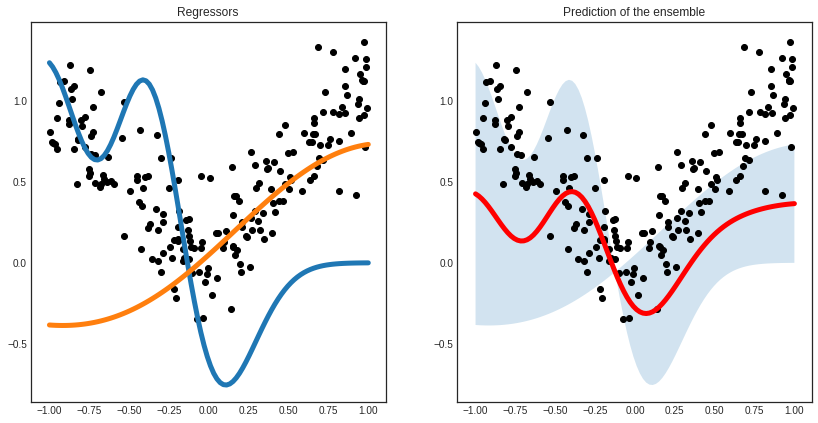

In [6]:
# visualizing the regressors
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(-1, 1, 100)

    plt.subplot(1, 2, 1)
    for learner_idx, learner in enumerate(committee):
        plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=5)
    plt.scatter(X, y, c='k')
    plt.title('Regressors')

    plt.subplot(1, 2, 2)
    pred, std = committee.predict(x.reshape(-1, 1), return_std=True)
    pred = pred.reshape(-1, )
    std = std.reshape(-1, )
    plt.plot(x, pred, c='r', linewidth=5)
    plt.fill_between(x, pred - std, pred + std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Prediction of the ensemble')
    plt.show()

After a few queries, the differences are smoothed out and the regressors reach an agreement.

In [7]:
# active regression
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X.reshape(-1, 1))
    committee.teach(X[query_idx].reshape(-1, 1), y[query_idx].reshape(-1, 1))

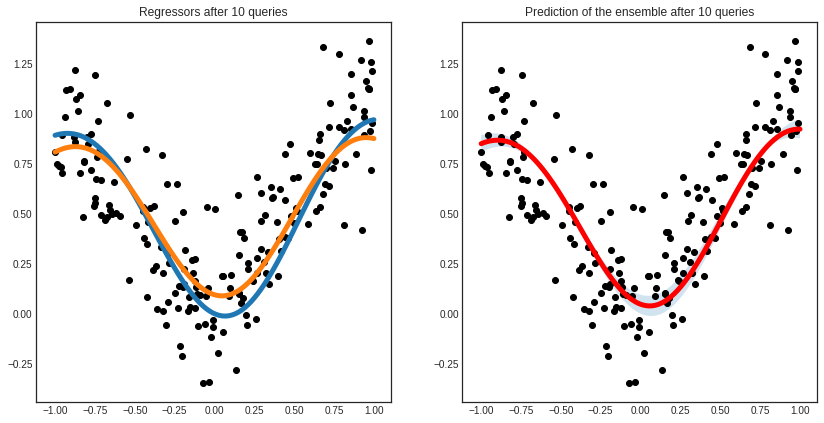

In [8]:
# visualizing the regressors
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(-1, 1, 100)

    plt.subplot(1, 2, 1)
    for learner_idx, learner in enumerate(committee):
        plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=5)
    plt.scatter(X, y, c='k')
    plt.title('Regressors after %d queries' % n_queries)

    plt.subplot(1, 2, 2)
    pred, std = committee.predict(x.reshape(-1, 1), return_std=True)
    pred = pred.reshape(-1, )
    std = std.reshape(-1, )
    plt.plot(x, pred, c='r', linewidth=5)
    plt.fill_between(x, pred - std, pred + std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Prediction of the ensemble after %d queries' % n_queries)
    plt.show()